<a href="https://colab.research.google.com/github/Rishabhjuneja/NYC-Taxi/blob/main/exploartion_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data: NYC Taxi (Green Trip data Feb 2016)
# Questions asked:
1. Download the data, load it into python. Report the number of rows and columns that you've loaded.

2. Visualize trip distance by time of day in any way you see fit, any observations?

3. What are the most popular pickup locations on weekends vs weekdays?

4. Build a model to forecast the number of trips by hour for the next 12 hours after Feb 12th 10:00 am. How well did you do?


Created By: Rishabh Juneja 

Date: 9th Aug 2021 

Company: Gale Partners

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [3]:
# Create spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
#Import Libraries
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import time
import folium
from folium import Choropleth ,  Circle, Marker
import datetime as dt
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# UDF to convert day to day type 
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [7]:
file_loc='./green_tripdata_2016-02.csv'
taxi_data = spark.read.csv(file_loc, inferSchema=True, header =True)

In [8]:
taxi_data.show(5)

+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|  Pickup_longitude|   Pickup_latitude| Dropoff_longitude|  Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |
+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|       2| 2016-02-01 00:00:01|  2016-02-01 00:10:06|                 N| 

In [9]:
# check number of rows & Coloums 

print((taxi_data.count(), len(taxi_data.columns)))

(1510722, 21)


In [10]:
# Check any missing values 

from pyspark.sql.functions import lit

rows = taxi_data.count()
summary = taxi_data.describe().filter(F.col("summary") == "count")
summary.select(*((F.lit(rows)-F.col(c)).alias(c) for c in taxi_data.columns)).show()

+--------+--------------------+---------------------+------------------+----------+----------------+---------------+-----------------+----------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|Pickup_longitude|Pickup_latitude|Dropoff_longitude|Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |
+--------+--------------------+---------------------+------------------+----------+----------------+---------------+-----------------+----------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|     0.0|                 0.0|                  0.0|               0.0|       0.0|             0

Insights: There is no Missing values in dataset 

In [ ]:
# Descriptive Statistics

taxi_data.describe().show()
 

+-------+-------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+---------+---------------------+------------------+------------------+-------------------+
|summary|           VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|        RateCodeID|   Pickup_longitude|   Pickup_latitude|  Dropoff_longitude|  Dropoff_latitude|  Passenger_count|     Trip_distance|       Fare_amount|              Extra|            MTA_tax|        Tip_amount|       Tolls_amount|Ehail_fee|improvement_surcharge|      Total_amount|      Payment_type|         Trip_type |
+-------+-------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+-------------------+---

Insights: There seems to be outliers in differenet coloums such as  trip distance , fare amount, extra , mat tax should be .5 , trip amount 

In [11]:
# Check quantile to deepdive check for outliers
pandastaxi_data = taxi_data.toPandas()
pandastaxi_data.quantile(q=0.5, axis=0, numeric_only=True, interpolation='linear')

VendorID                  2.000000
RateCodeID                1.000000
Pickup_longitude        -73.946754
Pickup_latitude          40.746536
Dropoff_longitude       -73.945587
Dropoff_latitude         40.746937
Passenger_count           1.000000
Trip_distance             1.800000
Fare_amount               9.000000
Extra                     0.500000
MTA_tax                   0.500000
Tip_amount                0.000000
Tolls_amount              0.000000
improvement_surcharge     0.300000
Total_amount             11.000000
Payment_type              1.000000
Trip_type                 1.000000
Name: 0.5, dtype: float64

In [12]:
# Convert to pandas for plotting graphs and checking outliers
pandas_taxi_data = taxi_data.toPandas()

# Check Trip Distance for outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


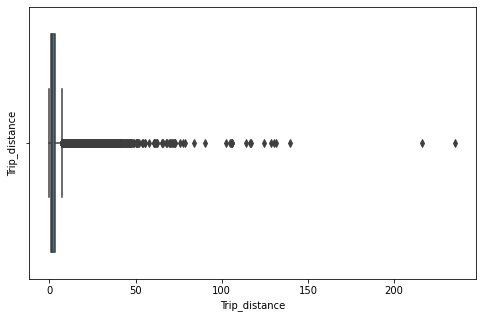

In [ ]:
# Plot trip distance to check outliers
plt.figure(figsize = (8,5))
sns.boxplot("Trip_distance", data = pandas_taxi_data, orient = "v")
plt.tick_params(labelsize = 10)
plt.ylabel("Trip_distance", fontsize = 10)
plt.show()

Study: There are some outliers but we should be looked deep into it

In [ ]:
# We investigate Quartiles (0-100)
tripDistance_quatile = pandas_taxi_data.Trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
values_q = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in values_q:
    print("{} miles are in {} percentile ".format( tripDistance_quatile[i],int(i*100)))

0.0 miles are in 0 percentile 
0.62 miles are in 10 percentile 
0.89 miles are in 20 percentile 
1.13 miles are in 30 percentile 
1.41 miles are in 40 percentile 
1.8 miles are in 50 percentile 
2.3 miles are in 60 percentile 
3.0 miles are in 70 percentile 
4.01 miles are in 80 percentile 
6.05 miles are in 90 percentile 
235.5 miles are in 100 percentile 


90th percentile is 5.98 and 100th is 235.5 so there are outliers and further investigate between 90 to 100

In [ ]:
tripDistance_quatile = pandas_taxi_data.Trip_distance.quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
values_q = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in values_q:
    print("{} miles are in {} percentile ".format( tripDistance_quatile[i],int(i*100)))

14.37 miles are in 99 percentile 
14.87 miles are in 99 percentile 
15.35 miles are in 99 percentile 
15.939999999999998 miles are in 99 percentile 
16.86 miles are in 99 percentile 
17.7 miles are in 99 percentile 
18.5 miles are in 99 percentile 
19.7 miles are in 99 percentile 
22.79 miles are in 99 percentile 
235.5 miles are in 100 percentile 


Insights: since 99.9 percentile is 22.8 and 100 is 235.5, so we will remove anything above 22.8

In [14]:
# Remove data with outliers of trip distance

data_tripdistance=taxi_data.where("Trip_distance < 22.8")

print((data_tripdistance.count(), len(data_tripdistance.columns)))


(1509212, 21)


# Check fare Amount for outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


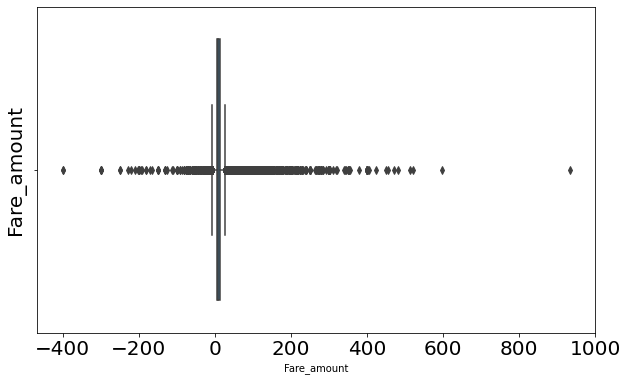

In [ ]:
# Plot Fare_amount to check outliers
plt.figure(figsize = (10,6))
sns.boxplot("Fare_amount", data = pandas_taxi_data, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Fare_amount", fontsize = 20)
plt.show()

Assumption: fare cant be negative so remove them and some outliers also

In [ ]:
Fare_amount_quatile = pandas_taxi_data.Fare_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
values_q = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in values_q:
    print("{} miles are in {} percentile ".format( Fare_amount_quatile[i],int(i*100)))

-400.0 miles are in 0 percentile 
4.5 miles are in 10 percentile 
5.5 miles are in 20 percentile 
6.5 miles are in 30 percentile 
7.5 miles are in 40 percentile 
9.0 miles are in 50 percentile 
10.5 miles are in 60 percentile 
13.0 miles are in 70 percentile 
16.5 miles are in 80 percentile 
22.5 miles are in 90 percentile 
933.5 miles are in 100 percentile 


In [ ]:
Fare_amount_quatile = pandas_taxi_data.Fare_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
values_q = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} miles are in {} percentile ".format( Fare_amount_quatile[i],int(i*100)))

48.0 miles are in 99 percentile 
50.0 miles are in 99 percentile 
51.5 miles are in 99 percentile 
52.0 miles are in 99 percentile 
52.0 miles are in 99 percentile 
54.0 miles are in 99 percentile 
58.5 miles are in 99 percentile 
65.0 miles are in 99 percentile 
77.5 miles are in 99 percentile 
933.5 miles are in 100 percentile 


Insights: remove anything elow 0 and above 77.5

In [15]:
# Remove data with outliers of fare amount

data_fareamount=data_tripdistance.where("Fare_amount between 0 and 77.5")

print((data_fareamount.count(), len(data_fareamount.columns)))


(1505528, 21)


# Total Amount Outliers

In [ ]:
total_amount_quatile = pandas_taxi_data.Total_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
values_q = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in values_q:
    print("{} miles are in {} percentile ".format( total_amount_quatile[i],int(i*100)))

-400.0 miles are in 0 percentile 
6.3 miles are in 10 percentile 
7.299999999999999 miles are in 20 percentile 
8.3 miles are in 30 percentile 
9.38 miles are in 40 percentile 
11.0 miles are in 50 percentile 
12.8 miles are in 60 percentile 
15.349999999999998 miles are in 70 percentile 
19.3 miles are in 80 percentile 
26.3 miles are in 90 percentile 
1121.16 miles are in 100 percentile 


In [ ]:
total_amount_quatile = pandas_taxi_data.Total_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
values_q = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} miles are in {} percentile ".format( total_amount_quatile[i],int(i*100)))

54.36 miles are in 99 percentile 
56.3 miles are in 99 percentile 
58.3 miles are in 99 percentile 
60.0 miles are in 99 percentile 
62.88 miles are in 99 percentile 
66.34 miles are in 99 percentile 
70.01 miles are in 99 percentile 
76.0 miles are in 99 percentile 
92.20999999999998 miles are in 99 percentile 
1121.16 miles are in 100 percentile 


Study: Remove anything below 0 and above 92.2

In [16]:
# Remove data with outliers of trip distance

data_distance=data_tripdistance.where("Total_amount between 0 and  22.8")

print((data_distance.count(), len(data_distance.columns)))


(1297720, 21)


# Other Outliers 

In [17]:
# Remove other outliers such as ratecodeid can't be >6 , MTA tax is 0.5, imrovement chargers is 0.3

taxi_data_no_outlier=data_distance.where("RateCodeID < 7").where("MTA_tax  = 0.5").where("improvement_surcharge = 0.3")


print((taxi_data_no_outlier.count(), len(taxi_data_no_outlier.columns)))


(1269864, 21)


Next Steps: Could have looked into other abnormalities like lat and long

# Add new coloums for model & Data Analysis

In [18]:
# get date and time coloum seprately for pickup and drop
from pyspark.sql import functions as F

split_col = F.split(taxi_data_no_outlier['lpep_pickup_datetime'], ' ')
split_col2 = F.split(taxi_data_no_outlier['Lpep_dropoff_datetime'], ' ')
taxi_data_no_outlier = taxi_data_no_outlier.withColumn('pickup_date', split_col.getItem(0)).withColumn('pickup_time', split_col.getItem(1)).withColumn('drop_date', split_col2.getItem(0)).withColumn('drop_time', split_col2.getItem(1))


taxi_data_no_outlier.show(5)

+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+-----------+-----------+----------+---------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|  Pickup_longitude|   Pickup_latitude| Dropoff_longitude|  Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |pickup_date|pickup_time| drop_date|drop_time|
+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+--------

In [19]:
# Convert to pandas
taxi_data_no_outlier_pandas = taxi_data_no_outlier.toPandas()

In [20]:
# Change date time to datetime format
taxi_data_no_outlier_pandas['pickup_datetime']=pd.to_datetime(taxi_data_no_outlier_pandas['lpep_pickup_datetime'])
taxi_data_no_outlier_pandas['dropoff_datetime']=pd.to_datetime(taxi_data_no_outlier_pandas['Lpep_dropoff_datetime'])

# Get day
taxi_data_no_outlier_pandas['pickup_day_number']=taxi_data_no_outlier_pandas['pickup_datetime'].dt.weekday
taxi_data_no_outlier_pandas['dropoff_day_number']=taxi_data_no_outlier_pandas['dropoff_datetime'].dt.weekday

# Get hour 
taxi_data_no_outlier_pandas['pickup_hour']=taxi_data_no_outlier_pandas['pickup_datetime'].dt.hour
taxi_data_no_outlier_pandas['dropoff_hour']=taxi_data_no_outlier_pandas['dropoff_datetime'].dt.hour

# Get day name
taxi_data_no_outlier_pandas['pickup_day']=taxi_data_no_outlier_pandas['pickup_datetime'].dt.day_name()
taxi_data_no_outlier_pandas['dropoff_day']=taxi_data_no_outlier_pandas['dropoff_datetime'].dt.day_name()

# Get time of day
taxi_data_no_outlier_pandas['pickup_timeofday']=taxi_data_no_outlier_pandas['pickup_hour'].apply(time_of_day)
taxi_data_no_outlier_pandas['dropoff_timeofday']=taxi_data_no_outlier_pandas['dropoff_hour'].apply(time_of_day)

In [21]:
# Display Data 
taxi_data_no_outlier_pandas

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,pickup_date,pickup_time,drop_date,drop_time,pickup_datetime,dropoff_datetime,pickup_day_number,dropoff_day_number,pickup_hour,dropoff_hour,pickup_day,dropoff_day,pickup_timeofday,dropoff_timeofday
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,2.86,10.5,0.5,0.5,0.00,0.0,None,0.3,11.80,2,1,2016-02-01,00:00:01,2016-02-01,00:10:06,2016-02-01 00:00:01,2016-02-01 00:10:06,0,0,0,0,Monday,Monday,Late night,Late night
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,3.35,13.0,0.5,0.5,0.00,0.0,None,0.3,14.30,2,1,2016-02-01,00:01:33,2016-02-01,00:20:13,2016-02-01 00:01:33,2016-02-01 00:20:13,0,0,0,0,Monday,Monday,Late night,Late night
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,4.70,17.5,0.5,0.5,3.76,0.0,None,0.3,22.56,1,1,2016-02-01,00:03:46,2016-02-01,00:21:04,2016-02-01 00:03:46,2016-02-01 00:21:04,0,0,0,0,Monday,Monday,Late night,Late night
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,2.11,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2,1,2016-02-01,00:00:05,2016-02-01,00:06:48,2016-02-01 00:00:05,2016-02-01 00:06:48,0,0,0,0,Monday,Monday,Late night,Late night
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,0.98,5.0,0.5,0.5,0.00,0.0,None,0.3,6.30,2,1,2016-02-01,00:06:20,2016-02-01,00:08:47,2016-02-01 00:06:20,2016-02-01 00:08:47,0,0,0,0,Monday,Monday,Late night,Late night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269859,1,2016-02-29 23:02:16,2016-02-29 23:14:25,N,1,-73.903435,40.745811,-73.865829,40.741482,1,2.40,10.5,0.5,0.5,0.00,0.0,None,0.3,11.80,2,1,2016-02-29,23:02:16,2016-02-29,23:14:25,2016-02-29 23:02:16,2016-02-29 23:14:25,0,0,23,23,Monday,Monday,Late night,Late night
1269860,1,2016-02-29 23:00:46,2016-02-29 23:10:08,N,1,-73.916656,40.757957,-73.881950,40.755867,1,1.90,9.0,0.5,0.5,0.00,0.0,None,0.3,10.30,2,1,2016-02-29,23:00:46,2016-02-29,23:10:08,2016-02-29 23:00:46,2016-02-29 23:10:08,0,0,23,23,Monday,Monday,Late night,Late night
1269861,1,2016-02-29 23:00:17,2016-02-29 23:15:02,N,1,-73.979424,40.688305,-73.923569,40.698891,1,3.30,13.0,0.5,0.5,3.55,0.0,None,0.3,17.85,1,1,2016-02-29,23:00:17,2016-02-29,23:15:02,2016-02-29 23:00:17,2016-02-29 23:15:02,0,0,23,23,Monday,Monday,Late night,Late night
1269862,1,2016-02-29 23:00:02,2016-02-29 23:06:22,N,1,-73.987488,40.702381,-73.995041,40.719868,1,2.20,8.5,0.5,0.5,2.90,0.0,None,0.3,12.70,1,1,2016-02-29,23:00:02,2016-02-29,23:06:22,2016-02-29 23:00:02,2016-02-29 23:06:22,0,0,23,23,Monday,Monday,Late night,Late night


# Data Analysis

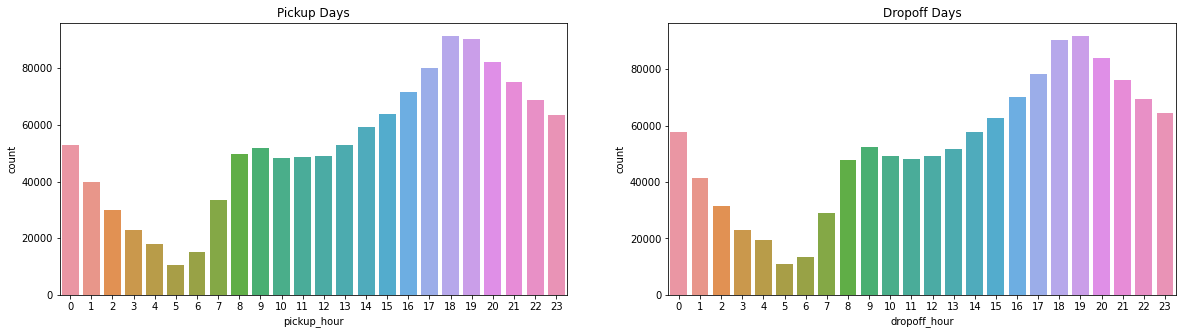

In [22]:
# Check pickup and drop of time of day trips

figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))

ax9.set_title('Pickup Days')
ax=sns.countplot(x="pickup_hour",data=taxi_data_no_outlier_pandas,ax=ax9)

ax10.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_hour",data=taxi_data_no_outlier_pandas,ax=ax10)

Insights: 1. Pickup and drop are highest furing evening time i.e. between 4PM and 8 PM

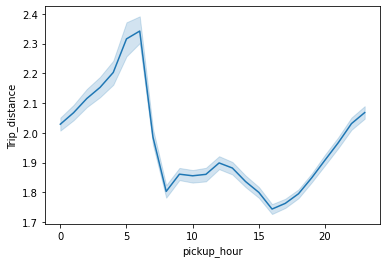

In [ ]:
sns.lineplot(data=taxi_data_no_outlier_pandas, x="pickup_hour", y="Trip_distance")

Insights: trip distance is highest in morning at 5AM fllowed by it sees increase after 4PM till midnight

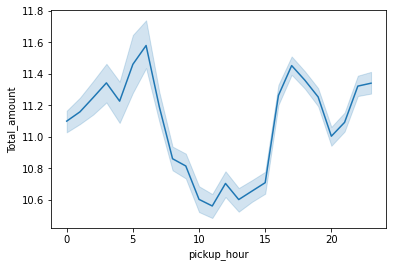

In [ ]:
# Pickup vs amount
sns.lineplot(data=taxi_data_no_outlier_pandas, x="pickup_hour", y="Total_amount")

Insights: trip amount shows similar behaviour as distance when compared to pikcup hour 

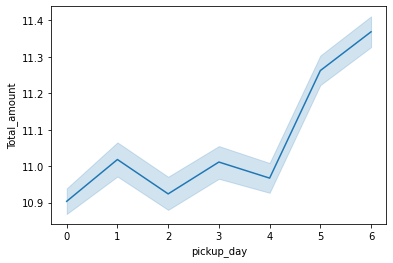

In [ ]:
# amount vs Day
sns.lineplot(data=taxi_data_no_outlier_pandas, x="pickup_day", y="Total_amount")

inisghts: Trip amount is highest on weekend i.e. sat & Sun 

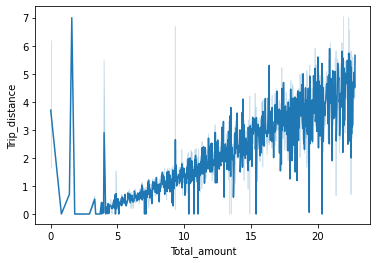

In [ ]:
# amount vs distance
sns.lineplot(data=taxi_data_no_outlier_pandas, x="Total_amount", y="Trip_distance")

Since there seems to correlation amoung variables we will test correlation

In [23]:
# Plot data based on Lat and Long 
import plotly.express as px

fig = px.scatter_mapbox(taxi_data_no_outlier_pandas, lat="Pickup_latitude", lon="Pickup_longitude", color="pickup_day", zoom=10)
fig.show()

# Check Correlation and Remove for Model

In [24]:
corr_data=taxi_data_no_outlier_pandas.corr(method ='kendall')

corr_data

,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,improvement_surcharge,Total_amount,Payment_type,Trip_type,pickup_day_number,dropoff_day_number,pickup_hour,dropoff_hour
VendorID,1.000000,-0.000158,0.039438,0.043199,0.034038,0.040829,0.037151,0.007241,0.004383,0.005094,NaN,-0.004946,-0.001003,NaN,0.004048,-0.019378,0.000654,0.003178,0.002881,0.013713,0.011573
RateCodeID,-0.000158,1.000000,0.013750,0.002253,0.013087,0.000900,0.000197,0.000632,0.003865,-0.009643,NaN,-0.006675,0.000509,NaN,0.002073,0.007838,-0.000019,-0.002729,-0.002782,-0.004682,-0.004569
Pickup_longitude,0.039438,0.013750,1.000000,0.229255,0.618882,0.221241,0.002443,-0.024327,-0.032980,0.006138,NaN,-0.176691,-0.009684,NaN,-0.064905,0.174821,0.000676,-0.006229,-0.006376,-0.021495,-0.021146
Pickup_latitude,0.043199,0.002253,0.229255,1.000000,0.157122,0.785670,-0.032470,-0.054258,-0.055961,-0.052663,NaN,-0.105432,0.007483,NaN,-0.078637,0.087407,0.001267,-0.040181,-0.040105,-0.031606,-0.027993
Dropoff_longitude,0.034038,0.013087,0.618882,0.157122,1.000000,0.172611,0.008937,-0.024043,-0.034521,0.049084,NaN,-0.191942,-0.019684,NaN,-0.065527,0.186825,0.000780,-0.003702,-0.003813,-0.000946,-0.002704
Dropoff_latitude,0.040829,0.000900,0.221241,0.785670,0.172611,1.000000,-0.032610,-0.071623,-0.073566,-0.058207,NaN,-0.112471,0.012042,NaN,-0.096112,0.092024,0.001629,-0.041559,-0.041409,-0.029531,-0.025776
Passenger_count,0.037151,0.000197,0.002443,-0.032470,0.008937,-0.032610,1.000000,0.007249,0.007024,0.028576,NaN,0.005780,0.000850,NaN,0.009747,-0.001352,-0.000511,0.019537,0.019207,0.014844,0.013301
Trip_distance,0.007241,0.000632,-0.024327,-0.054258,-0.024043,-0.071623,0.007249,1.000000,0.843241,-0.013532,NaN,0.151372,0.038578,NaN,0.770924,-0.076723,-0.001048,0.038354,0.038031,-0.015927,-0.016486
Fare_amount,0.004383,0.003865,-0.032980,-0.055961,-0.034521,-0.073566,0.007024,0.843241,1.000000,-0.024188,NaN,0.155533,0.032382,NaN,0.857698,-0.073759,-0.001266,0.026994,0.026943,-0.015938,-0.014490
Extra,0.005094,-0.009643,0.006138,-0.052663,0.049084,-0.058207,0.028576,-0.013532,-0.024188,1.000000,NaN,0.014445,-0.016445,NaN,0.054365,-0.010657,-0.000308,-0.107286,-0.105467,0.238980,0.228166


There is strong correlation between trip distance with fare amount and total amount so we will remove those variables and other non used variables

# Remove correlated variables 

In [25]:
# Select Coloums required 
clean_data_pandas=taxi_data_no_outlier_pandas[[	'pickup_datetime'	,'pickup_day_number',	'pickup_hour'	,'pickup_timeofday',	'VendorID',	'Store_and_fwd_flag',	'RateCodeID',		'Passenger_count',	'Trip_distance'	,'Payment_type']]



In [28]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [27]:
# change pandas to spark dataframe
cleaned_data = spark.createDataFrame(clean_data_pandas)

# Check data is staionary or not

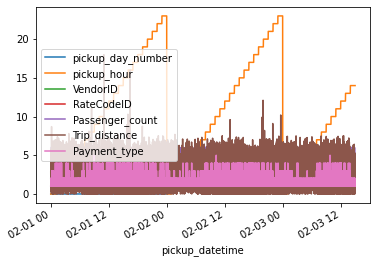

In [ ]:

from matplotlib import pyplot
import matplotlib.pyplot as plt
clean_data_pandas.plot(x='pickup_datetime')
pyplot.show()

Data is non staionary

# Create final table for Model

In [29]:
# Change all coloums types of int or float
cleaned_data_strflg=cleaned_data.withColumn("Store_and_fwd_code", F.when(cleaned_data.Store_and_fwd_flag == 'N', F.lit(0)).otherwise(F.lit(1))).drop("Store_and_fwd_flag")

cleaned_data2=cleaned_data_strflg.withColumn("Class",F.when(cleaned_data_strflg.pickup_timeofday == 'Morning', F.lit(1)).when(cleaned_data_strflg.pickup_timeofday == 'Afternoon',F.lit(1)).when(cleaned_data_strflg.pickup_timeofday == 'Evening',F.lit(2)).otherwise(3)).drop("pickup_timeofday").distinct()

cleaned_data2.distinct().count()

1269388

In [30]:
# Add a coloum number of trips for forceasting

trips=cleaned_data2.groupby("pickup_hour","pickup_day_number").agg(F.count(F.lit(1)).alias("trips"))

cleaned_data_final=cleaned_data2.join(trips,(cleaned_data2.pickup_hour==trips.pickup_hour) & (cleaned_data2.pickup_day_number==trips.pickup_day_number)).select(cleaned_data2["*"],trips.trips)

cleaned_data_final.distinct().count()

1269388

In [31]:
# Check max and min pickup time for dividing between test and control 
cleaned_data.agg(F.min("pickup_datetime").alias("min_date"),F.max("pickup_datetime").alias("max_date")).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2016-02-01 00:00:01|2016-02-29 23:59:53|
+-------------------+-------------------+



In [32]:
# Divide test and train (base on date Feb 12th 10:00 am)

train=cleaned_data_final.where("pickup_datetime < '2016-02-12 10:00:00'").drop("pickup_datetime")

test=cleaned_data_final.where("pickup_datetime between '2016-02-12 10:00:00' and '2016-02-12 22:00:00'").drop("pickup_datetime")

In [33]:
# To pandas
train_pandas = train.toPandas()
test_pandas = test.toPandas()

In [37]:
# Divide data for model fit
y_train = train_pandas['trips']
x_train = train_pandas.drop(['trips'],axis=1)

y_test = test_pandas['trips']
x_test = test_pandas.drop(['trips'],axis=1)

# Build Model, fit and test

In [38]:
# get Model details and run it
xgbr = xgb.XGBRegressor(verbosity=0) 
print(xgbr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [39]:
# Model fit
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

In [40]:
# get Training score
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

Training score:  0.984571442452499


Insights: Training scores are very high shows more accuracy of data

In [41]:
# Check cross validation score for 2nd check of model

scores = cross_val_score(xgbr, x_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


Mean cross-validation score: 0.94


Insights: Cross validation score is 90 % which makes sure model is effecient

In [42]:
#Get RMSE Score
y_pred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

print("RMSE: %.2f" % (mse**(1/2.0)))


RMSE: 566.41


Inisghts: RMSE score is 

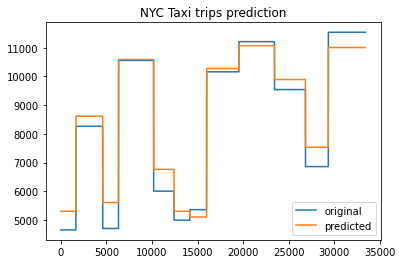

In [50]:
# Plot graph to check accuracy and difference between original and predicted 
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("NYC Taxi trips prediction")
plt.legend()
plt.show()

Insights: graph clearly states that model is predicting values very close to original 